In [2]:
# multiple seedds
##############################################################
############### Correlation 2 WITH SWITCH  ################################
##############################################################
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from tqdm import tqdm

file_format= 'PNG'

results_dir = './results/'
exp_name = 'new_code'
exp_name = 'MD_yes_no_data_runs'

files = os.listdir(results_dir + exp_name+'/')
rates_files = [file for file in files if 'saved_rates' in file]
weights_files = [file for file in files if 'saved_weights' in file]

# strings to look for in filtering file for each experiemnt to compare 
comp_one = 's_1.0_' # with with OFC switches 180
comp_two = 's_0.0_' # with MD clampped to one neuron

comp_one_files = [os.path.join(results_dir+exp_name,file) for file in rates_files if comp_one in file]
comp_two_files = [os.path.join(results_dir+exp_name,file) for file in rates_files if (comp_two in file)]

print(f'comp_one_files:')
comp_one_files

comp_one_files:


['./results/MD_yes_no_data_runs/fig_saved_rates_1.0_1.0_8_20210305-083415.pickle']

In [3]:
for fi, file_name in enumerate(comp_one_files[:]):

    filehandler = open(file_name, 'rb')
    rates_one = pickle.load(filehandler)
    filehandler.close()
    PFCrates, MDinputs, MDrates, Outrates, Inputs, Targets, MSEs= rates_one

In [4]:
Outrates.shape

(5000, 200, 2)

In [5]:
Inputs.shape

(5000, 8)

In [6]:
Targets.shape

(5000, 2)

In [7]:
from config import Config
from error_computations import Error_computations
import plot_utils as pltu
config = Config({'seed': 8})
Ntrain = config.Nblocks * config.trials_per_block
tpb = config.trials_per_block


config.horizon = 5
self = Error_computations(config)

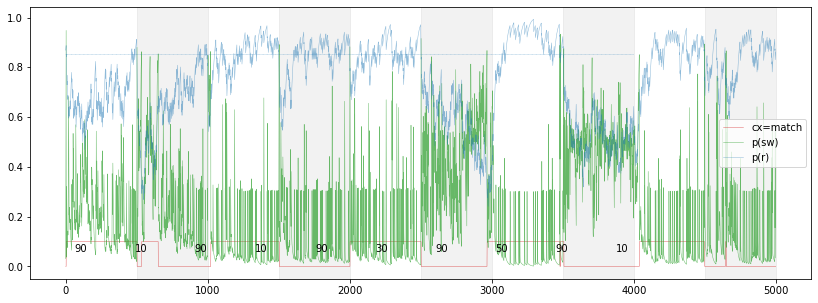

In [16]:
results = []
switch_thresh = 0.85
# for traini in range(1450, 1500): #Ntrain):
for traini in range(Ntrain):
#     ec.update_v(Inputs[traini, :2], Outrates[traini], Targets[traini])
    stimulus = Inputs[traini, :2]
    target = Targets[traini]
    choice = Outrates[traini]
    T = len(self.trial_history)
    ####
    trial_type = "MATCH" if (stimulus == target).all() else "NON-MATCH"
    self.trial_history.append(trial_type)
    if len(self.trial_history) > config.horizon: self.trial_history = self.trial_history[-self.horizon:]

    horizon = [t == "MATCH" for t in self.trial_history]
    choices = self.Sabrina_Q_values if self.current_context is "MATCH" else np.flip(self.Sabrina_Q_values)
#     print(horizon)
    current_reward = target[np.argmax(choice.mean(axis=0))] # 1 if choice is correct, 0 otherwise
#     print('cue: ', stimulus, ' target', target, ' choice: ', choice.mean(axis=0), ' argmax: ', np.argmax(choice.mean(axis=0)))
    self.p_reward = 0.95 * self.p_reward + 0.05 * current_reward 
    choices = np.array([self.p_reward, 1-self.p_reward])


    # It should be: get current behavior (match vs non), and if matches current context belief (match vs non). 
    # because sometimes behavior might not match belief fully. Flip the trials that do not match belief.
    # Fast forward, get true "Match" "nonMatch" trials ground truth. Which I have already!!
    # horizon = trial_history == current_belief !!!!
    # stay_votes = np.choose(horizon, [1-p_reward, p_reward])
    horizon = [t == self.current_context for t in self.trial_history]
    choices = np.array([1-self.p_reward, self.p_reward])
    stay_votes = np.choose(horizon, choices) #Makes no sense. It made sense when I had choices as v1 v2, but now it is p(r)

    leave_votes = 1- stay_votes
    ratio_switch_t = []
    for t in range(T):
        like_switch = np.prod(stay_votes[:t]) * np.prod(leave_votes[t:])
        like_stay   = np.prod(stay_votes)
        ratio_switch_t.append( like_switch/ (like_switch + like_stay) )

    #Integrating from all horizon:
    ratio_switch = np.array(ratio_switch_t).mean()
    p_sm_T = 1. if self.current_context == "MATCH" else 0. 
    p_snm_T = ratio_switch 
    p_ns_T = self.p_reward 
    self.p_sm_snm_ns = np.array ([p_sm_T, p_snm_T, p_ns_T])

    if ratio_switch > switch_thresh: #flip context
        if self.current_context is "MATCH": 
            self.current_context = "NON-MATCH"
        else: 
            self.current_context = "MATCH"
        #Note: reset reward
#         self.p_reward = 0.1
        #get trial with max switch prob:
        max_t = np.argmax(ratio_switch_t)
        # Purge all trial history entries before. Assume it is where the switch happened.
#         self.trial_history = self.trial_history[max_t:]

    ####
    
    results.append(self.p_sm_snm_ns)

results = np.stack(results)
cxt = 0 # current context belief
p_sw = 1 # p(switch)
p_r = 2 # p(reward)

fig, axes = plt.subplots(1,1, figsize=[14,5]) 
ax = axes
ax.plot(results[:,cxt]*.1, color='tab:red', alpha=0.7,   linewidth=0.5, label='cx=match')
st = tpb*3 - 10
d = 30
# ax.plot(range(st, st+d), results[st:st+d, p_sw], 'o', markersize= 2, linewidth=0.5, color='tab:blue', alpha=0.7,   label='sw_dots')
ax.plot(results[:,p_sw], color='tab:green', alpha=0.7, linewidth=0.5, label='p(sw)')
ax.plot(results[:,p_r], color='tab:blue', alpha=0.5, linewidth=0.5, label='p(r)')
ax.plot(range(4000), switch_thresh * np.ones(4000), '--', linewidth=0.25)    
for bi in range(config.Nblocks): # LABEL contexts
    plt.text((1/13)* (0.74+bi), 0.1, str(config.block_schedule[bi]), transform=ax.transAxes)
for ib in range(1, config.Nblocks,2): # demarcate contexts with grey shading
    ax.axvspan(tpb* ib, tpb*(ib+1), alpha=0.1, color='grey')
    
ax.legend()
# fig.savefig('bayesian_switch_signal.png', dpi=1200)